In [1]:
import tqdm
import pickle
import random
import xgboost
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

import xgboost as xgb
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)
synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]

In [3]:
TEST_SIZE = 0.3
RANDOM_SEED = 42

def get_metrics(y_true, y_pred, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    pr, rc, _ = pr_curve = precision_recall_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(rc, pr)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "fpr": fpr,
        "tpr": tpr,
        "pr": pr,
        "rc": rc,
        "roc_auc": roc_auc,
    }    

def get_datasets(X: np.ndarray, y: np.ndarray, test_size: float = TEST_SIZE, balanced: bool = True, random_seed=RANDOM_SEED):
    n_pos = y.sum()
    n_neg = (~y).sum()
    
    _X = X - 0.45
    # Creating the datasets
    X_pos, y_pos = X.loc[y], y.loc[y]
    X_neg, y_neg = X.loc[~y], y.loc[~y]
    
    # Creating balanced datasets: subsample the negative data
    # to make the positive and negative data compatible
    if balanced:
        i = np.arange(n_neg)
        i_neg = np.random.choice(i, n_pos)
        X_neg, y_neg = X_neg.iloc[i_neg], y_neg.iloc[i_neg]

    # Use the same number of positive-negative points in the train/test sets
    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, test_size=test_size, random_state=random_seed)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size=test_size, random_state=random_seed)
    
    # concatenate the datasets
    concat_fn = pd.concat if isinstance(X, pd.DataFrame) else np.concatenate
    
    X_train = concat_fn([X_train_pos, X_train_neg])
    X_test = concat_fn([X_test_pos, X_test_neg])
    y_train = concat_fn([y_train_pos, y_train_neg]).astype(int)
    y_test = concat_fn([y_test_pos, y_test_neg]).astype(int)
    
    return X_train, X_test, y_train, y_test

## Feature importance

In [5]:
clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
)

results = []
_LABELS = synth.columns
THRESHOLD = 0.25
MINIMUM_POSITIVE = 10

for _label in tqdm.tqdm_notebook(["Ge"]):
    # Get the information for the dataset
    X = dm
    y = (synth[_label] > THRESHOLD)
    
    n_pos = y.sum()

    if n_pos <= MINIMUM_POSITIVE:
        continue
    
    X_train, X_test, y_train, y_test = get_datasets(X, y, balanced=True)

    # Fitting the classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    results.append({
        "label": _label,
        "classifier": type(clf).__name__,
        "y_test": y_test,
        "y_pred": y_pred,
        "n_pos": y_train.sum(),
        "n_neg": (1 - y_train).sum(),
        **get_metrics(y_test, y_pred, y_score),
    })

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_31373/101447848.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _label in tqdm.tqdm_notebook(["Ge"]):


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
bst = clf.get_booster()

In [7]:
importance = pd.Series(clf.feature_importances_, index=dm.index)

In [8]:
with open("../data/iza_mst_nx.pkl", "rb") as f:
    G = pickle.load(f)

/Users/schwalbekoda1/envs/zeo/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:466: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


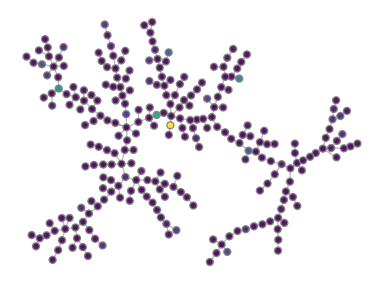

In [10]:
fig, ax = plt.subplots(figsize=(4, 3))

pos = nx.get_node_attributes(G, "pos")

options = {
    "edgecolors": "tab:gray",
    "node_size": 25,
    "alpha": 0.9,
    "cmap": "inferno",
    "vmin": 0,
    "vmax": 1,
}

colors = np.array([
    importance[G.nodes[n]["zeo"]]
    for n in G.nodes
])
norm = plt.Normalize(colors.min(), colors.max())

colors = [cm.viridis(norm(x)) for x in colors]


nx.draw_networkx_nodes(G, pos, node_color=colors, ax=ax, **options)

for i, j in G.edges:
    xy = np.stack([pos[i], pos[j]])
    ax.plot(xy[:, 0], xy[:, 1], linewidth=1.0, color="#808080", alpha=0.5, zorder=-1)

ax.axis("off")

plt.tight_layout()

# fig.savefig("iza-tmap.pdf", bbox_inches="tight", transparent=True)
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


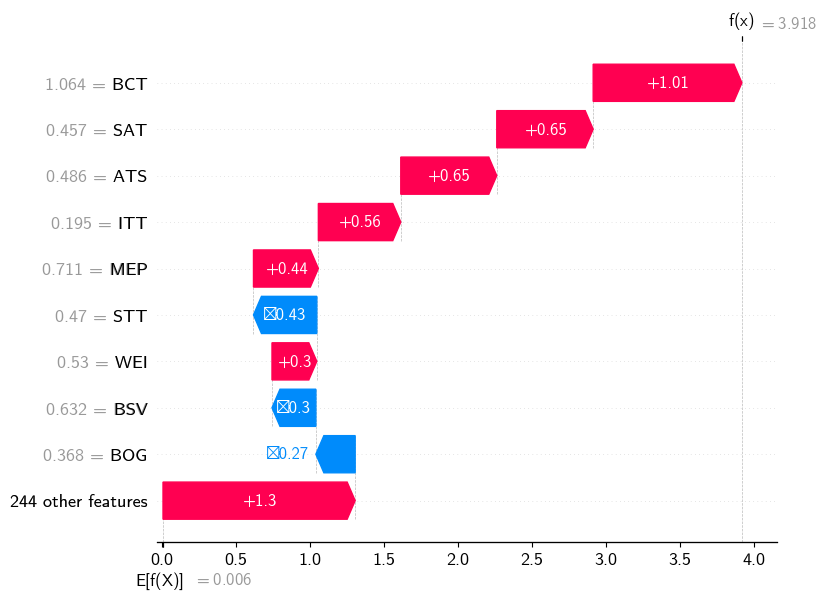

In [12]:
import shap

# Calculate SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_test)

# Plot SHAP values for a specific instance
shap.plots.waterfall(shap_values[7])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


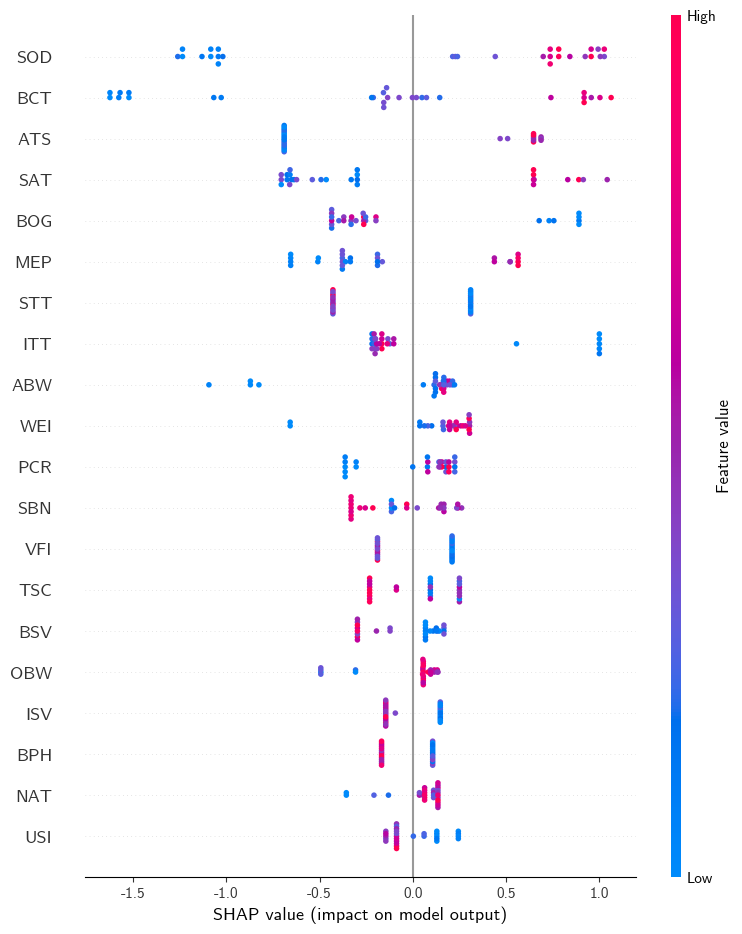

In [13]:
shap.summary_plot(shap_values, X_test)

## Trying feature importance

In [14]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

In [15]:
X_test

,ABW,ACO,AEI,AEL,AEN,AET,AFG,AFI,AFN,AFO,...,UWY,VET,VFI,VNI,VSV,WEI,WEN,YFI,YUG,ZON
zeolite,,,,,,,,,,,,,,,,,,,,,
SYT,1.026094,0.962488,0.414596,1.168991,1.252438,1.133840,0.858047,0.968070,0.872540,1.111919,...,0.723391,1.272049,0.875476,0.931055,0.880921,0.743215,0.746478,0.748520,1.018510,0.912073
JST,0.759332,0.725371,0.658972,1.097359,1.068890,1.119900,0.784915,1.118019,0.810587,1.097764,...,0.948283,1.218200,0.995631,0.696628,0.628411,0.470811,0.662127,0.902474,0.759322,0.923310
MON,0.244482,0.398183,0.662081,0.573032,0.529479,0.628566,0.238188,0.594079,0.230972,0.606430,...,0.369701,0.726865,0.504296,0.275747,0.333147,0.443123,0.401747,0.410628,0.240806,0.418772
UTL,0.447626,0.798051,0.633726,0.483043,0.509381,0.476847,0.389981,0.361095,0.323249,0.429719,...,0.166349,0.584465,0.237366,0.388894,0.628652,0.694093,0.496448,0.170124,0.354906,0.208559
SOV,0.507959,0.640083,0.467450,0.620681,0.743615,0.596966,0.332543,0.449306,0.363867,0.598698,...,0.193186,0.741496,0.372317,0.424165,0.462376,0.544365,0.327598,0.229824,0.490045,0.393939
UOS,0.342394,0.642043,0.531113,0.334415,0.427335,0.386620,0.294051,0.308534,0.205094,0.331196,...,0.170923,0.506003,0.209301,0.267199,0.473961,0.520056,0.369947,0.184463,0.240741,0.121030
BOG,0.399172,0.750197,0.561922,0.534516,0.625517,0.517015,0.314609,0.389790,0.263312,0.484998,...,0.106961,0.630410,0.308249,0.333958,0.556849,0.631484,0.444973,0.115770,0.355894,0.285152
IRR,0.707446,0.660002,0.440001,0.781220,0.958132,0.793574,0.551680,0.608101,0.577066,0.806726,...,0.410977,0.955863,0.489447,0.645038,0.563967,0.529738,0.419273,0.439877,0.710918,0.594528
EWO,0.391556,0.737144,0.767075,0.183541,0.429336,0.313272,0.438844,0.273676,0.411308,0.159252,...,0.367533,0.324010,0.397483,0.466424,0.665963,0.675593,0.532948,0.386567,0.446260,0.273758


In [236]:
preds = [
    partial_dependence(clf, X_train, [col])
    for col in X_train.columns
]

In [238]:
pdp = pd.Series([
    np.mean(p["average"])
    for p in preds
], index=X_train.columns)

In [241]:
pdp.sort_values(ascending=False).iloc[:20]

SOD    0.536778
BOZ    0.520342
AFT    0.512534
AFV    0.510493
STT    0.507654
SBN    0.506625
AEI    0.505818
AST    0.505040
JST    0.503998
GIS    0.502533
WEI    0.501933
SVV    0.501360
JSN    0.501295
POR    0.500714
NPO    0.500604
OKO    0.500504
ATS    0.500488
ETL    0.500444
PTT    0.500345
DFO    0.500345
dtype: float32

In [242]:
pdp.sort_values(ascending=True).iloc[:20]

MSO    0.490760
ABW    0.495997
FAR    0.496200
MEP    0.496562
ITG    0.497313
APC    0.497363
PWO    0.498293
WEN    0.498366
IRR    0.498749
EUO    0.498987
IRN    0.499265
OFF    0.499365
CLO    0.499388
ETR    0.499415
AFI    0.499449
RHO    0.499524
SVY    0.499547
PHI    0.499630
STW    0.499704
AVE    0.499764
dtype: float32

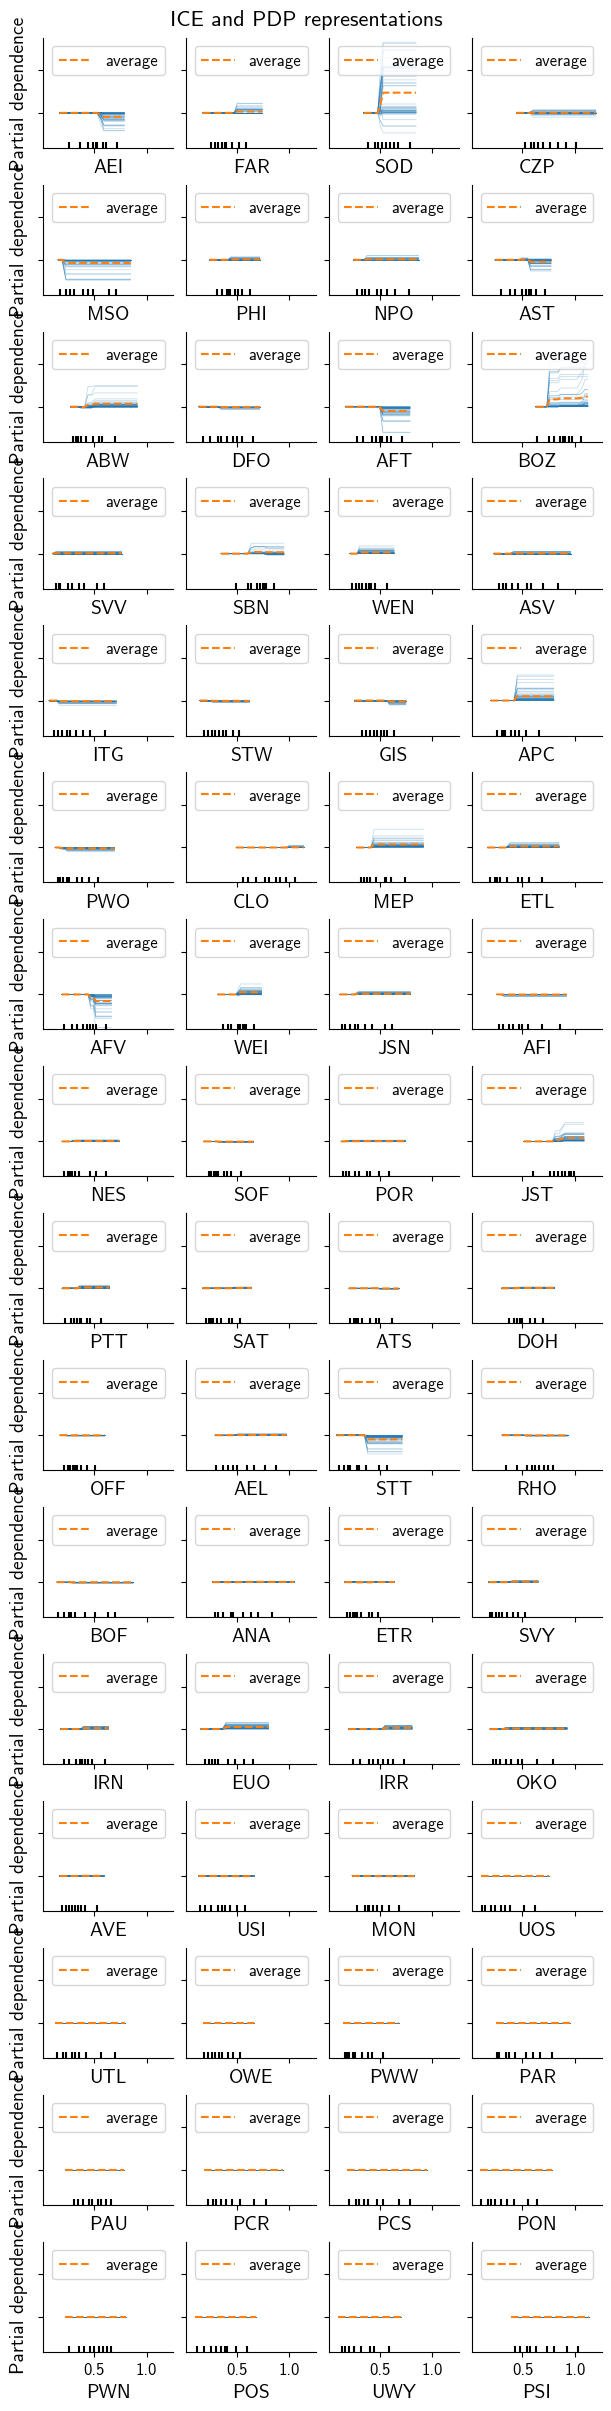

In [231]:
n_features = 64
_, ax = plt.subplots(16, 4, figsize=(6, 24), sharey=True, sharex=True, constrained_layout=True)

# _features = synth["Ge"].sort_values(ascending=False).iloc[:n_features].index
_features = importances.sort_values(ascending=False).iloc[:n_features].index
features_info = {
    "features": _features,
    "kind": "both",
    "centered": True,
}

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

display = PartialDependenceDisplay.from_estimator(
    clf,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

In [230]:
synth.loc["MSO"]

Al                 1.0
As                 0.0
B                  0.0
Be                 0.0
Ca                 0.0
Ce                 0.0
Cl                 0.0
Co                 0.0
Cr                 0.0
Cs                 0.0
Cu                 0.0
F                  0.0
Fe                 0.0
Ga                 0.0
Ge                 0.0
H2SO4              0.0
HNO3               0.0
K                  1.0
Li                 0.0
Mg                 0.0
Mn                 0.0
Na                 0.0
Ni                 0.0
P                  0.0
Rb                 0.0
S                  0.0
SO4                0.0
Si                 1.0
Sn                 0.0
Sr                 0.0
Te                 0.0
Ti                 0.0
V                  0.0
Zn                 0.0
ethanol            0.0
ethylene glycol    0.0
ethylenediamine    0.0
seed               0.0
Name: MSO, dtype: float64